# Goal

The goal of this notebook is to use unsupervised learning techniques as KMeans to create a feature which can be incorporated to the dataset. I will try to identify similar instances and assigning them to clusters.

This notebook has been created after the full project was finished so it is an attemp to improve the metrics of the price prediction models as well as a review of the clustering techniques studied in the master. Also it will helps us to make some cool and fancy visualizations with dimensionality reduction techniques (DataViz).

# Import Dependencies and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from daftpy.daftmodel import split_data, transformer_estimator

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load Data

In [3]:
data = pd.read_csv('data/selected_data.csv', sep=',')
data.shape 

(7344, 9)

**Variables**

In [4]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
#num_features.remove('longitude')
#num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

# Make DataFrames to present the features
num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

# Merge both DataFrames
feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

numerical categorical
0  floor_area       place
1     bedroom  type_house
2    bathroom            
3   longitude            
4    latitude

**Categorical Variables Levels**

In [5]:
# Add `Unknown` to give it to missing values and not have an error  with levels
levels_type_house = list(data.type_house.unique())
levels_type_house.append('Unknown')
levels_type_house.remove(np.nan)
#levels_type_house = np.append(levels_type_house, 'Unknown')
levels_place = list(data.place.unique())
levels_place.append('Unknown')
levels_place.remove(np.nan)

levels_list = [levels_place, levels_type_house]

cat_feat_df['n_levels'] = [levels_place, levels_type_house] #, levels_city_district
cat_feat_df['sample'] = [levels_place[:5], levels_type_house] #, levels_city_district[:4]
cat_feat_df # mejorar

categorical                                           n_levels  \
0       place  [Naas, Wexford, Dublin 8, Dublin 6W, Carrick o...   
1  type_house                        [house, apartment, Unknown]   

                                              sample  
0  [Naas, Wexford, Dublin 8, Dublin 6W, Carrick o...  
1                        [house, apartment, Unknown]

**Input Data**

In [6]:
features = [
    'price',
    'floor_area',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
    'type_house',
#    'city_district',
    'place']

data = data[features].copy()
data.shape

(7344, 8)

# Split Data

In [7]:
X, y = split_data(data=data, 
                  target='price', 
                  test_size=.15, 
                  output='X_y',
                  random_state=7)

X: (7344, 7)
y: (7344,)


# KMeans

## Data Transformation

I will apply the same transformations as in *Price_Prediction* notebook.

In [8]:
transformer = transformer_estimator(num_transformation='power_transformer',
                                    levels_list=levels_list,
                                    num_feat=num_features,
                                    cat_feat=cat_features,
                                    poly_degree=1,
                                    regressor=None)

X_transformed = transformer.fit_transform(X)
X_transformed.shape

(7344, 145)

## Optimal Number Of Clusters

### Elbow-Inertia Method

In [9]:
# Number of maximum clusters tried 
max_cluster = 10
# Initialise inertia dictionary 
inertia_dict = {}
# Looping starting with 1 cluster and then
for n_clusters in range(1, max_cluster + 1):
    # Calculate the kmeans with clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=7)  #, n_init=10  MiniBatchKMeans
    y_pred = kmeans.fit(X_transformed)
    
    inertia_dict[n_clusters] = kmeans.inertia_

inertia_dict

{1: 46413.14705882342,
 2: 34179.42532320067,
 3: 29317.584117754184,
 4: 26308.004983175884,
 5: 23848.721291058027,
 6: 22098.689999148668,
 7: 20888.2928029287,
 8: 19840.361544405998,
 9: 19021.682392137758,
 10: 18371.91349425628}

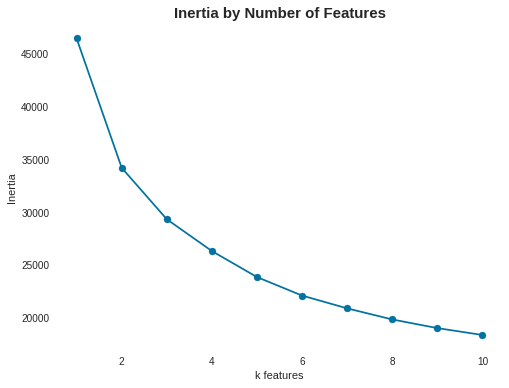

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(x=inertia_dict.keys(), y=inertia_dict.values())
plt.plot(inertia_dict.keys(), inertia_dict.values())

ax.set_title('Inertia by Number of Features', weight='bold', size=15)
ax.set_xlabel('k features')
ax.set_ylabel('Inertia')
ax.grid()

for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)

It seems like two features is the optimal number of features since it is when inertia goes down more but it is no clear. Let's try the silhouette score method.

### Silhoutte Score Method

In [11]:
# Number of maximum clusters tried 
max_cluster = 10
# Initialise silhouette dictionary 
silhouette_dict = {}
# Looping starting with 2 clusters and then
for cluster in range(2, max_cluster + 1):    
    # Calculate the kmeans with clusters
    kmeans = KMeans(n_clusters=cluster, random_state=7)
    y_pred = kmeans.fit(X_transformed)
    
    silhouette_dict[cluster] = silhouette_score(X_transformed, kmeans.labels_)
    
silhouette_dict

{2: 0.22173240163292515,
 3: 0.20375364000627125,
 4: 0.1778290597626677,
 5: 0.19663389697961664,
 6: 0.18187643212429777,
 7: 0.1721470484872364,
 8: 0.17208001600264758,
 9: 0.16042087433141436,
 10: 0.15764214894822884}

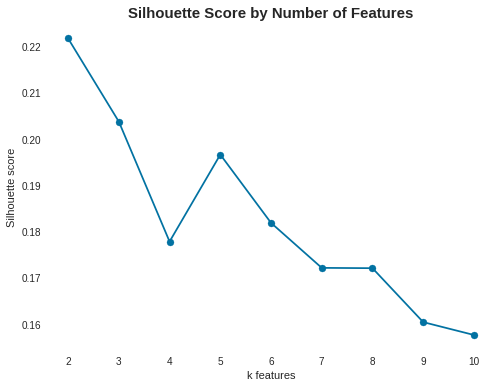

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(x=silhouette_dict.keys(), y=silhouette_dict.values())
plt.plot(silhouette_dict.keys(), silhouette_dict.values())

ax.set_title('Silhouette Score by Number of Features', weight='bold', size=15)
ax.set_xlabel('k features')
ax.set_ylabel('Silhouette score')
ax.grid()

for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)

The graph shows that the optimal number of features is two since two clusters return the best score.

## KMeans Training

In [13]:
# Train KMeans to two clusters
kmeans = KMeans(n_clusters=2, random_state=7)
y_pred = kmeans.fit(X_transformed)

kmeans.labels_

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [14]:
# Create new column with the cluster labels
X['cluster'] = kmeans.labels_

We can now plot the data using the coordinates and differentiating the clusters by colors.

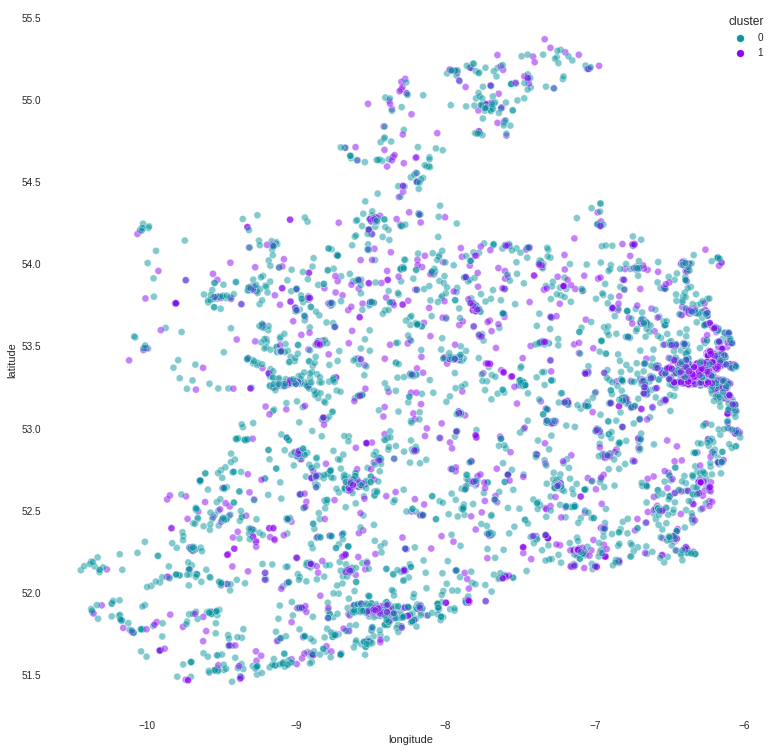

In [15]:
fig, ax = plt.subplots(figsize=(13, 13))

sns.scatterplot(data=X, x='longitude', y='latitude', 
                hue='cluster', ax=ax, 
                palette={-1:'red', 0:'#0896A1', 1:'#8C05F4', 2:'#EE0CBD',
                         3:'#0C15EE', 4:'#0CF631', 5:'#8C05F4', 6:'#8C05F4',
                         7:'red', 8:'#0896A1', 9:'black', 10:'yellow'
                        }, ##8C05F4
                alpha=.5, 
                #size='cluster'
               )  
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
ax.grid(visible=False)

It is difficult to see any pattern plotting the data like this so it would be interesting to project the variables onto a 2-dimensional and a 3-dimensional plane and plotting the results.

## Dimensionality Reduction with PCA

In [16]:
# X_transformed is a sparse matrix
X_transformed

<7344x145 sparse matrix of type '<class 'numpy.float64'>'
	with 51408 stored elements in Compressed Sparse Row format>

The PCA will identify the hyperplane that lies closest to the data and then it will project the data onto it.

As I am choosing two and three components the PCA algorithm will do the following:
- For two components it will take the axis that accounts for the largest amount of variance and then the one that accounts for the largest amount of remaining variance. They are the first and second principal components.
- For three components the process is the same but instead taking axis it will take hyperplanes that account for the largest amount of variance.

In [17]:
pca = PCA(n_components=2)
# It is necessary convert the sparse matrix to an array before fitting 
X2D = pca.fit_transform(X_transformed.toarray())

In [18]:
print(f'1st component variance: {round(pca.explained_variance_ratio_[0], 2)*100}%')
print(f'2nd component variance: {round(pca.explained_variance_ratio_[1], 2)*100}%')
print(f'Total variance explained: {round(sum(pca.explained_variance_ratio_), 2)*100}%')

1st component variance: 40.0%
2nd component variance: 20.0%
Total variance explained: 60.0%


It will be easiers to transform the data to a DataFrame in order to plot it.

In [19]:
X2D = pd.DataFrame(X2D, columns=['PC1', 'PC2'])
# Add the cluster labels column
X2D['cluster'] = kmeans.labels_
X2D.head()

PC1       PC2  cluster
0  2.763335  0.104569        0
1  1.158186 -0.797768        0
2 -0.094517  0.209696        1
3  1.347056 -0.052257        0
4 -2.105491 -0.509886        1

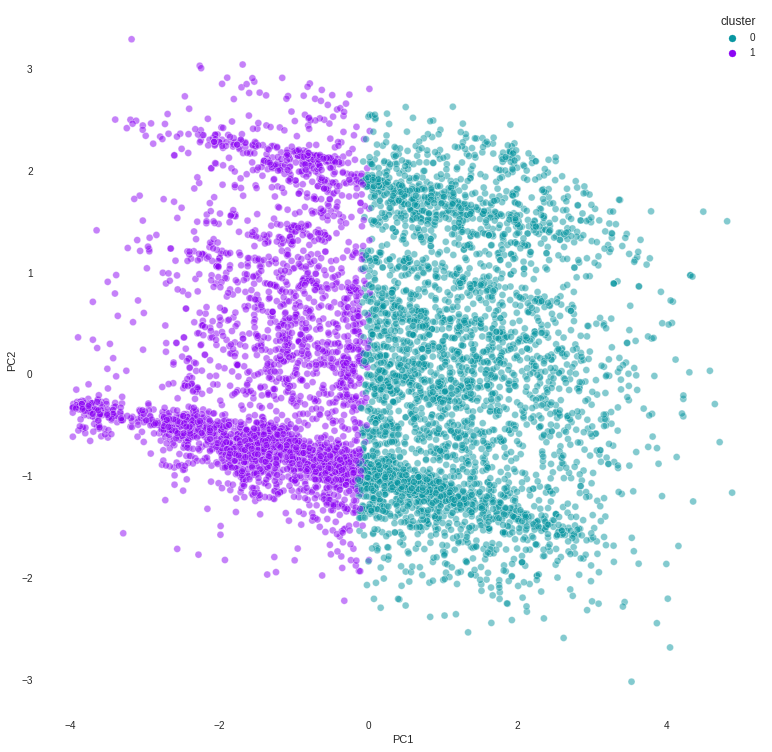

In [20]:
fig, ax = plt.subplots(figsize=(13, 13))

sns.scatterplot(data=X2D, x=X2D.PC1, y=X2D.PC2, 
                hue='cluster', 
                ax=ax, 
                palette={-1:'red', 0:'#0896A1', 1:'#8C05F4', 2:'#EE0CBD',
                         3:'#0C15EE', 4:'#0CF631', 5:'#8C05F4', 6:'#8C05F4',
                         7:'red', 8:'#0896A1', 9:'black', 10:'yellow'},
                alpha=.5)  
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
ax.grid(visible=False)

Now let's do the same process choosing three components.

In [21]:
pca = PCA(n_components=3)

X3D1 = pca.fit_transform(X_transformed.toarray())

X3D1 = pd.DataFrame(X3D1, columns=['PC1', 'PC2', 'PC3'])
X3D1['cluster'] = kmeans.labels_
X3D1.head()

PC1       PC2       PC3  cluster
0  2.763335  0.104569  1.079960        0
1  1.158186 -0.797768 -0.463631        0
2 -0.094517  0.209696 -1.333107        1
3  1.347056 -0.052257 -1.417834        0
4 -2.105491 -0.509886 -0.192984        1

In [22]:
print(f'1st component variance: {round(pca.explained_variance_ratio_[0], 2)*100}%')
print(f'2nd component variance: {round(pca.explained_variance_ratio_[1], 2)*100}%')
print(f'2nd component variance: {round(pca.explained_variance_ratio_[2], 2)*100}%')
print(f'Total variance explained: {round(sum(pca.explained_variance_ratio_), 2)*100}%')

1st component variance: 40.0%
2nd component variance: 20.0%
2nd component variance: 11.0%
Total variance explained: 71.0%


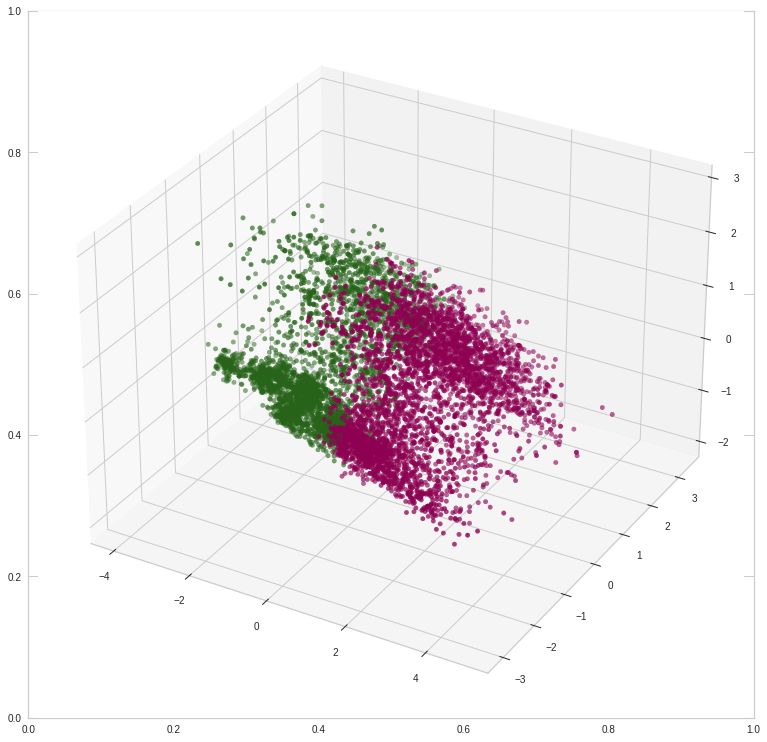

In [23]:
fig, ax = plt.subplots(figsize=(13, 13))
ax = plt.axes(projection='3d')

ax.scatter3D(X3D1.PC1, X3D1.PC2, X3D1.PC3,
             c=X3D1.cluster, cmap='PiYG');

It is possible to plot the above figure making it interactive. I will use the Plotly library to do that.

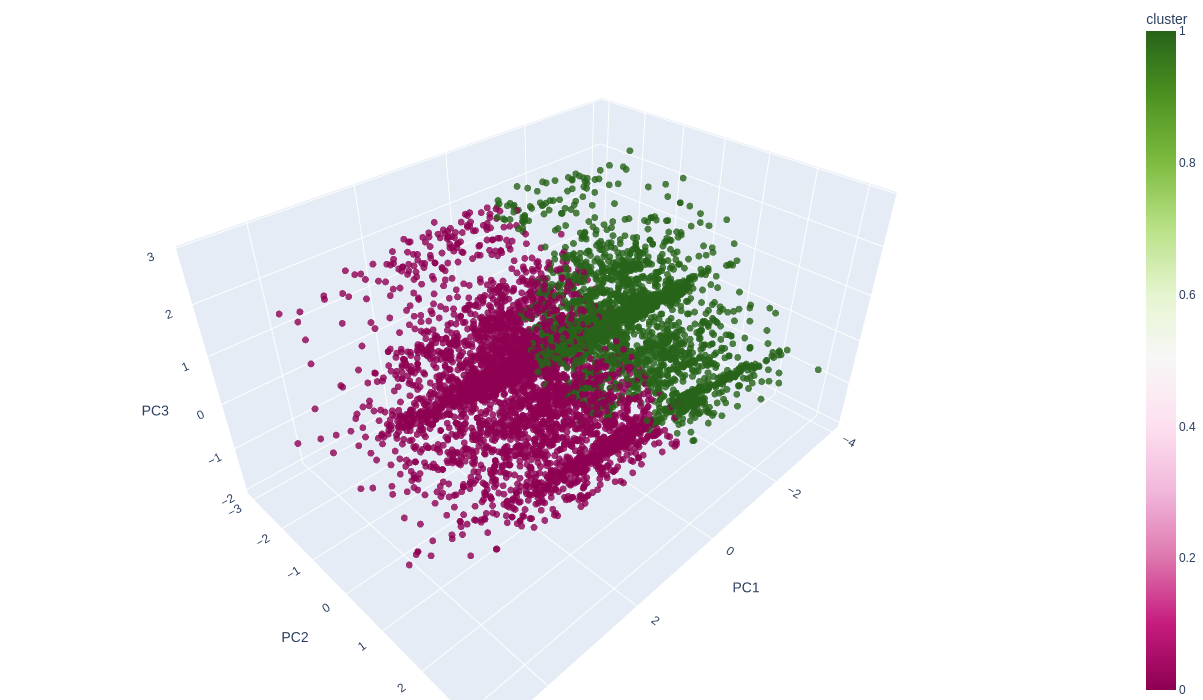

In [24]:
import plotly.express as px

fig = px.scatter_3d(X3D1, x=X3D1.PC1, y=X3D1.PC2, z=X3D1.PC3,
                    color=X3D1.cluster, 
                    opacity=0.8,
                    color_continuous_scale=px.colors.diverging.PiYG, 
                    height=700)
fig.update_traces(marker_size = 4)
#fig.show()

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In the last plots it is easier to see patterns than in the scatter plot made with the coordinates as axis. We can quickly identify the two clusters above.

# Save Clusters

In [25]:
clusters = X.cluster.copy()
clusters.sample(3)

1792    0
4315    0
3285    1
Name: cluster, dtype: int32

In [26]:
clusters.to_csv('data/cluster.csv', sep=',', index=False)